In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [73]:
# simulate mean firing rate for neurons at random
n_cells = 250
directions = 8
trials = 8

# assume avg spikes happen with uniform probabilities
exp = np.random.uniform(0.01, 0.99, size=(n_cells, trials*directions))

In [74]:
def direction_cosines(v: np.ndarray) -> np.ndarray:
    basis = np.array([[1,0,0], [0,1,0], [0,0,1]])
    normalize = lambda v: v / np.linalg.norm(v)

    cos_x = normalize(v) @ basis[0]
    cos_y = normalize(v) @ basis[1]
    cos_z = normalize(v) @ basis[2]
    
    return np.array([cos_x, cos_y, cos_z])


vertices = [
    (1, 1, 1), 
    (-1, 1, 1), 
    (-1, -1, 1), 
    (1, -1, 1), 
    (1, 1, -1), 
    (-1, 1, -1), 
    (-1, -1, -1), 
    (1, -1, -1)
    ]


# direction cosines of cube vertices
Ms = np.array([direction_cosines(v) for v in vertices])
Ms

array([[ 0.57735027,  0.57735027,  0.57735027],
       [-0.57735027,  0.57735027,  0.57735027],
       [-0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [-0.57735027,  0.57735027, -0.57735027],
       [-0.57735027, -0.57735027, -0.57735027],
       [ 0.57735027, -0.57735027, -0.57735027]])

In [75]:
# sanity check
print("vector norm of vertices:")
for i in range(len(Ms)):
    m_x, m_y, m_z = Ms[i]
    print(np.sqrt((m_x**2 + m_y**2 + m_z**2)), end="  ")

vector norm of vertices:
1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

In [84]:
exp_df = pd.DataFrame(exp,
                      index=[f"cell{i}" for i in range(n_cells)],
                      columns=[f"trial{i}" for i in range(trials*directions)]
                      ).T

exp_df['direction'] = np.repeat(np.arange(directions), trials)
exp_df

,cell0,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,cell9,...,cell241,cell242,cell243,cell244,cell245,cell246,cell247,cell248,cell249,direction
trial0,0.402852,0.477589,0.116791,0.712352,0.250100,0.139038,0.971749,0.710370,0.892210,0.879543,...,0.724044,0.320011,0.609917,0.158498,0.035974,0.383890,0.180013,0.385834,0.051058,0
trial1,0.515386,0.199238,0.291214,0.656538,0.718083,0.917314,0.857805,0.870916,0.799526,0.930092,...,0.233819,0.125860,0.658722,0.177888,0.851605,0.240122,0.177584,0.623399,0.432960,0
trial2,0.278772,0.388926,0.198079,0.877719,0.093547,0.424010,0.062384,0.237815,0.818232,0.580375,...,0.726609,0.920021,0.674655,0.184053,0.741330,0.475458,0.595504,0.490198,0.419483,0
trial3,0.331504,0.149295,0.783382,0.818465,0.593929,0.717898,0.066848,0.718622,0.076228,0.335668,...,0.428136,0.769253,0.718147,0.307897,0.572309,0.352781,0.043755,0.240034,0.256895,0
trial4,0.408295,0.945179,0.600814,0.717408,0.195743,0.694055,0.503204,0.337706,0.888764,0.023958,...,0.302085,0.730533,0.514207,0.701734,0.539994,0.076934,0.051018,0.438602,0.351336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
trial59,0.406425,0.332479,0.187325,0.619105,0.272867,0.635036,0.475737,0.762421,0.889770,0.565090,...,0.696741,0.124441,0.808832,0.971497,0.920290,0.854452,0.394346,0.277123,0.255523,7
trial60,0.156309,0.569593,0.894877,0.267857,0.701535,0.937635,0.668307,0.763461,0.720521,0.250084,...,0.141399,0.868724,0.579791,0.024104,0.156330,0.367955,0.665713,0.502243,0.152204,7
trial61,0.721034,0.283918,0.739917,0.221279,0.412395,0.342064,0.097326,0.596866,0.076710,0.521077,...,0.563089,0.866535,0.128401,0.082522,0.338154,0.158196,0.035242,0.261672,0.908444,7
trial62,0.265914,0.813264,0.686419,0.103411,0.373217,0.623979,0.954985,0.525429,0.488106,0.836183,...,0.098030,0.262239,0.372428,0.942462,0.819204,0.072598,0.686268,0.670757,0.631312,7


assume in `trialN` N is the vertex number, ie each trial corresponds to a particular direction. 
we test directional tuning by ANOVA

In [131]:
# ANOVA to test for if cells respond differently to different directions

pvals = []

for cell in exp_df.columns[:-1]:
    formula = f'{cell} ~ C(direction)'
    lm = sm.formula.ols(formula, data=exp_df).fit()
    table = sm.stats.anova_lm(lm)

    pvals.append(table['PR(>F)'][0])


idxs_directional = [i for i, p in enumerate(pvals) if p < 0.05]
assert idxs_directional

In [140]:
directional_df = exp_df.iloc[:, [*idxs_directional, -1]]
directional_df

,cell14,cell27,cell40,cell57,cell70,cell74,cell76,cell84,cell94,cell138,cell153,cell172,cell180,cell192,cell202,cell206,direction
trial0,0.917055,0.258178,0.508894,0.126653,0.056102,0.239712,0.907741,0.309511,0.391893,0.966266,0.619774,0.233230,0.828045,0.616362,0.044839,0.187410,0
trial1,0.362048,0.679158,0.398244,0.233737,0.027287,0.059762,0.751242,0.065011,0.671262,0.481646,0.940382,0.448446,0.262536,0.192433,0.408979,0.102152,0
trial2,0.199002,0.516634,0.594969,0.273878,0.972488,0.624455,0.319879,0.806967,0.650334,0.797992,0.454831,0.281432,0.212383,0.844452,0.063778,0.116254,0
trial3,0.646060,0.579213,0.184618,0.736149,0.049442,0.114745,0.450510,0.412783,0.848246,0.490132,0.403714,0.301489,0.300374,0.864364,0.765648,0.638772,0
trial4,0.039547,0.625859,0.045148,0.433909,0.439841,0.136560,0.457893,0.670774,0.363088,0.847235,0.959188,0.345497,0.250362,0.738211,0.065327,0.339459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
trial59,0.271661,0.891897,0.323519,0.353071,0.160677,0.522648,0.254982,0.652008,0.644635,0.518517,0.834681,0.331909,0.215223,0.945857,0.520835,0.352602,7
trial60,0.456285,0.607828,0.335646,0.775100,0.016454,0.568027,0.143106,0.314782,0.565628,0.378649,0.972895,0.898942,0.029244,0.122217,0.439422,0.112750,7
trial61,0.787291,0.097292,0.804510,0.348249,0.593150,0.217715,0.889562,0.900435,0.630785,0.181830,0.832141,0.523591,0.069408,0.864466,0.639857,0.401493,7
trial62,0.161162,0.657278,0.646687,0.737696,0.765217,0.734880,0.728825,0.965470,0.225230,0.472746,0.013732,0.711458,0.629548,0.671116,0.966914,0.667378,7


In [177]:
np.tile(Ms[4], (8,1))
# or rather fit all directions? unclear from paper

array([[ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027]])

In [185]:
cell14 = directional_df[directional_df.direction == 0].iloc[:, 0]
d_M = cell14.values

Ms_ = sm.add_constant(np.tile(Ms[0], (8,1)), has_constant='add')
model = sm.OLS(d_M, Ms_).fit()
predictions = model.predict(Ms_)

model.pvalues

array([0.00563972, 0.00563972, 0.00563972, 0.00563972])

In [253]:
def compute_direction_vector(neuron: np.ndarray, Ms: np.ndarray) -> tuple[np.ndarray, bool]:
    # mean firing rate for the 8 trials
    d_M = np.mean(neuron, axis=0)

    d_M = d_M.flatten()
    
    # fit linear regression
    M_ = sm.add_constant(Ms)
    model = sm.OLS(d_M, M_).fit()
    predictions = model.predict(M_)
    directional = all(model.pvalues <= 0.05) # True iff all bs below alpha lvl
    
    # extract coefficients (bs)
    b, b_x, b_y, b_z = model.params

    # direction cosines of preferred direction
    k = np.sqrt(b_x**2 + b_y**2 + b_z**2)
    C = np.array([b_x/k, b_y/k, b_z/k])
    
    # vector weight
    d_M_avg = np.mean(d_M) # average firing rate accross trials
    w_M = d_M_avg - b
    
    # wighted direction vector
    N_M = w_M * C
    
    return N_M, directional


def compute_direction_vector(neuron: np.ndarray, Ms: np.ndarray) -> tuple[np.ndarray, bool]:
    # mean firing rate for the 8 trials
    d_M = np.mean(neuron, axis=0)
    d_M = d_M.flatten()
    
    # fit linear regression
    Ms_ = sm.add_constant(Ms, has_constant='add')
    model = sm.OLS(d_M, Ms_).fit()
    predictions = model.predict(Ms_)
    directional = all(model.pvalues <= 0.05) # True iff all bs below alpha lvl
    
    # extract coefficients (bs)
    b, b_x, b_y, b_z = model.params

    # direction cosines of preferred direction
    k = np.sqrt(b_x**2 + b_y**2 + b_z**2)
    C = np.array([b_x/k, b_y/k, b_z/k])
    
    # vector weight
    d_M_avg = np.mean(d_M) # average firing rate accross trials
    w_M = d_M_avg - b
    
    # wighted direction vector
    N_M = w_M * C
    
    return N_M, directional


In [254]:
vectors = np.zeros((n_cells, 3))
dirs = []
for n in range(n_cells):
    vec, directional = compute_direction_vector(exp[:,:,n], Ms)
    # vec, directional = compute_direction_vector(exp[:,:,n] , np.tile(Ms[0], (8,1)))
    vectors[n,:] = vec
    dirs.append(directional)

# compute population vector
print(f"Proportion directional: {np.mean(dirs)*100}%")

population_vector = np.sum(vectors, axis=0)
print(f"Population vector: {population_vector}")

print(f"Average cell vector magnitude: {np.mean([np.linalg.norm(v) for v in vectors])}")

Proportion directional: 1.6%
Population vector: [ 1.67104399e-15 -1.91364492e-16 -3.61842390e-16]
Average cell vector magnitude: 1.1435297153639113e-16


1.6710439870964496e-15
2.220446049250313e-16


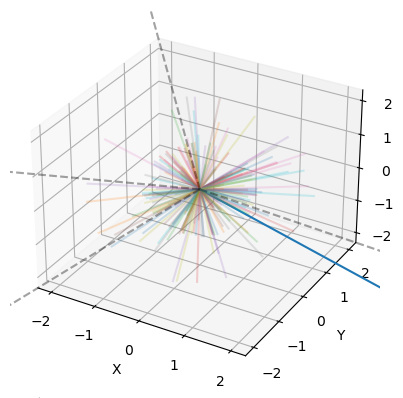

In [255]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def plot_vectors_3d(vectors, mov_axes=False):
    # Plot each vector as a line

    if mov_axes: 
        for v in vectors: 
            ax.plot([0, v[0]], [0, v[1]], [0, v[2]], alpha=0.2, linestyle='--', color='k')
        return

    if vectors.shape == (3,): # single vector
        v = vectors
        ax.plot([0, v[0]], [0, v[1]], [0, v[2]])
        max_dim = max(abs(v[0]), abs(v[1]), abs(v[2]))
    else:
        for v in vectors: ax.plot([0, v[0]], [0, v[1]], [0, v[2]], alpha=0.2)
        max_dim = max(max(abs(v[0]), abs(v[1]), abs(v[2])) for v in vectors)

    # set the limits of the plot
    ax.set_xlim([-max_dim, max_dim])
    ax.set_ylim([-max_dim, max_dim])
    ax.set_zlim([-max_dim, max_dim])
    print(max_dim) # BUG ticks are wrong?

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


plot_vectors_3d(population_vector)
plot_vectors_3d(vectors)
plot_vectors_3d(np.array(vertices), mov_axes=True)

### compute angle

In [256]:
def compute_angle(v1: np.ndarray, v2: np.ndarray) -> np.float64:
    normalize = lambda v: v / np.linalg.norm(v)
    # v1_u, v2_u = v1, v2
    v1_u, v2_u = normalize(v1), normalize(v2)
    return np.arccos(np.clip((v1_u @ v2_u), -1.0, 1.0))

for vertex in vertices:
    angle = np.degrees(compute_angle(population_vector, vertex))
    print(f"Angle between vertex {vertex} and population vector: {angle}")

Angle between vertex (1, 1, 1) and population vector: 67.96793144188275
Angle between vertex (-1, 1, 1) and population vector: 138.28099634516295
Angle between vertex (-1, -1, 1) and population vector: 128.1688257145736
Angle between vertex (1, -1, 1) and population vector: 59.764041760934816
Angle between vertex (1, 1, -1) and population vector: 51.83117428542642
Angle between vertex (-1, 1, -1) and population vector: 120.2359582390652
Angle between vertex (-1, -1, -1) and population vector: 112.03206855811725
Angle between vertex (1, -1, -1) and population vector: 41.719003654837074


## non-random spike trains

In [257]:
# simulate neurons over 8 trials
n_cells = 250
T = 1000 # ms
trials = 8
directions = 8

# exp = np.zeros((T, trials, directions, n_cells))

# 8 trials, each involves movement in specific direction
# -> on each trial only a select population responds

exp_two = np.random.rand(T, trials, directions, n_cells)

for direction, cell in zip(range(directions), range(0, n_cells, 25)):
    exp_two[:, :, direction, cell:cell+25] += 0.25

exp_two = np.round(np.clip(exp_two, 0, 1))

cells 0 - 175 are directionally tuned, the rest are not

In [258]:
np.mean(np.mean(exp_two[:, :, :, 0], axis=0).T, axis=1)

array([0.751625, 0.50725 , 0.488875, 0.502625, 0.49575 , 0.493375,
       0.504   , 0.50525 ])

In [259]:
ar = np.mean(exp_two[:, :, :, 0], axis=0)

ar.T.flatten().shape

(64,)

In [260]:
Ms

array([[ 0.57735027,  0.57735027,  0.57735027],
       [-0.57735027,  0.57735027,  0.57735027],
       [-0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [-0.57735027,  0.57735027, -0.57735027],
       [-0.57735027, -0.57735027, -0.57735027],
       [ 0.57735027, -0.57735027, -0.57735027]])

In [261]:
np.mean(np.mean(exp_two[:, :, :, 0], axis=0), axis=0)

array([0.751625, 0.50725 , 0.488875, 0.502625, 0.49575 , 0.493375,
       0.504   , 0.50525 ])

In [262]:
MMs = np.repeat(Ms, 8, axis=0)
MMs.shape

(64, 3)

In [264]:
compute_direction_vector(exp_two[:, :, :, 5], MMs)

(array([ 2.07440574e-16, -2.05571740e-17, -2.59767926e-16]), False)

In [265]:
vectors = np.zeros((n_cells, 3))
dirs = []
for n in range(n_cells): # TODO
    for i in range(directions):
        ms = np.tile(Ms[i], (8,1))
        vec, directional = compute_direction_vector(exp_two[:,:,i,n], ms)
        vectors[n,:] = vec
        dirs.append(directional)

# compute population vector
print(f"Proportion directional: {np.mean(dirs)*100}%")

population_vector = np.sum(vectors, axis=0)
print(f"Population vector: {population_vector}")

print(f"Average cell vector magnitude: {np.mean([np.linalg.norm(v) for v in vectors])}")

Proportion directional: 100.0%
Population vector: [ 37.96283701 -37.96283701 -37.96283701]
Average cell vector magnitude: 0.26301425000000006
